In [8]:
# %% [markdown]
# # Task 4 — Forecasting (2025–2027) with Scenarios + Uncertainty
#
# **Data constraint reality (from EDA):**
# - `ACC_OWNERSHIP`: 6 points → can fit a simple trend model with uncertainty.
# - `ACC_MM_ACCOUNT`: 2 points → too sparse for time-series; use scenario extrapolation.
# - `USG_TELEBIRR_USERS`: 1 point (2025) → treat 2025 as observed; forecast 2026–2027 with bounded adoption.
# - `USG_P2P_VALUE` (ETB): 1 point (2025) → treat 2025 as observed; forecast 2026–2027 with scenario nominal growth.
#
# **Deliverables:**
# - Forecast table for 2025–2027 (baseline/upside/downside) with method notes
# - Plots showing historical + forecasts
# - Save artifact: `data/processed/task4_forecasts.csv`

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)

DATA_PATH = "../data/processed/ethiopia_fi_unified_data_enriched.csv"
df = pd.read_csv(DATA_PATH)
df["observation_date"] = pd.to_datetime(df["observation_date"], errors="coerce")

obs = df[df["record_type"].eq("observation")].copy()

def parse_numeric_frame(d: pd.DataFrame) -> pd.Series:
    """Robust numeric parsing from value_numeric (preferred) or value_text (fallback)."""
    if "value_numeric" in d.columns:
        s = pd.to_numeric(d["value_numeric"], errors="coerce")
        if s.notna().any():
            return s

    if "value_text" in d.columns:
        raw = d["value_text"].astype(str)
        cleaned = raw.str.replace(",", "", regex=False).str.replace("%", "", regex=False)
        cleaned = cleaned.str.replace(r"[^0-9\.\-]", "", regex=True)
        return pd.to_numeric(cleaned, errors="coerce")

    return pd.Series([np.nan] * len(d), index=d.index)

def get_series(code: str) -> pd.DataFrame:
    """Return a tidy time series DataFrame with observation_date, year, y, unit, source_name."""
    d = obs[obs["indicator_code"].eq(code)].dropna(subset=["observation_date"]).copy()
    d["y"] = parse_numeric_frame(d)
    d = d.dropna(subset=["y"]).sort_values("observation_date")

    keep = [c for c in ["observation_date", "y", "unit", "source_name"] if c in d.columns]
    out = d[keep].copy()
    out["year"] = out["observation_date"].dt.year.astype(int)
    return out

targets = ["ACC_OWNERSHIP", "ACC_MM_ACCOUNT", "USG_TELEBIRR_USERS", "USG_P2P_VALUE"]
for t in targets:
    td = get_series(t)
    print(t, "n=", len(td))
    display(td)

ACC_OWNERSHIP n= 6


,observation_date,y,unit,source_name,year
0,2014-12-31,22.0,%,Global Findex 2014,2014
1,2017-12-31,35.0,%,Global Findex 2017,2017
2,2021-12-31,46.0,%,Global Findex 2021,2021
3,2021-12-31,56.0,%,Global Findex 2021,2021
4,2021-12-31,36.0,%,Global Findex 2021,2021
5,2024-11-29,49.0,%,Global Findex 2024,2024


ACC_MM_ACCOUNT n= 2


,observation_date,y,unit,source_name,year
6,2021-12-31,4.70,%,Global Findex 2021,2021
7,2024-11-29,9.45,%,Global Findex 2024,2024


USG_TELEBIRR_USERS n= 1


,observation_date,y,unit,source_name,year
20,2025-06-30,54840000.0,users,Ethio Telecom Report,2025


USG_P2P_VALUE n= 1


,observation_date,y,unit,source_name,year
16,2025-07-07,5.777000e+11,ETB,EthSwitch Annual Report,2025


In [9]:
# %%
acc = get_series("ACC_OWNERSHIP")
if len(acc) < 4:
    raise ValueError("ACC_OWNERSHIP has too few points for even a basic trend model.")

X = np.vstack([np.ones(len(acc)), acc["year"].values]).T
y = acc["y"].values
beta = np.linalg.lstsq(X, y, rcond=None)[0]
a, b = float(beta[0]), float(beta[1])

acc = acc.copy()
acc["y_hat"] = X @ beta
acc["resid"] = acc["y"] - acc["y_hat"]

rmse = float(np.sqrt(np.mean(acc["resid"]**2)))

print(f"Fit: y = {a:.3f} + {b:.3f}*year")
print("RMSE:", rmse)
display(acc)

Fit: y = -5646.289 + 2.816*year
RMSE: 6.234102588802836


,observation_date,y,unit,source_name,year,y_hat,resid
0,2014-12-31,22.0,%,Global Findex 2014,2014,24.710526,-2.710526
1,2017-12-31,35.0,%,Global Findex 2017,2017,33.157895,1.842105
2,2021-12-31,46.0,%,Global Findex 2021,2021,44.421053,1.578947
3,2021-12-31,56.0,%,Global Findex 2021,2021,44.421053,11.578947
4,2021-12-31,36.0,%,Global Findex 2021,2021,44.421053,-8.421053
5,2024-11-29,49.0,%,Global Findex 2024,2024,52.868421,-3.868421


,indicator_code,unit,year,baseline,downside,upside,method
0,ACC_OWNERSHIP,%,2025,55.684211,47.263158,67.263158,linear_trend + bootstrap_residuals (80% interval)
1,ACC_OWNERSHIP,%,2026,58.500000,50.078947,70.078947,linear_trend + bootstrap_residuals (80% interval)
2,ACC_OWNERSHIP,%,2027,61.315789,52.894737,72.894737,linear_trend + bootstrap_residuals (80% interval)


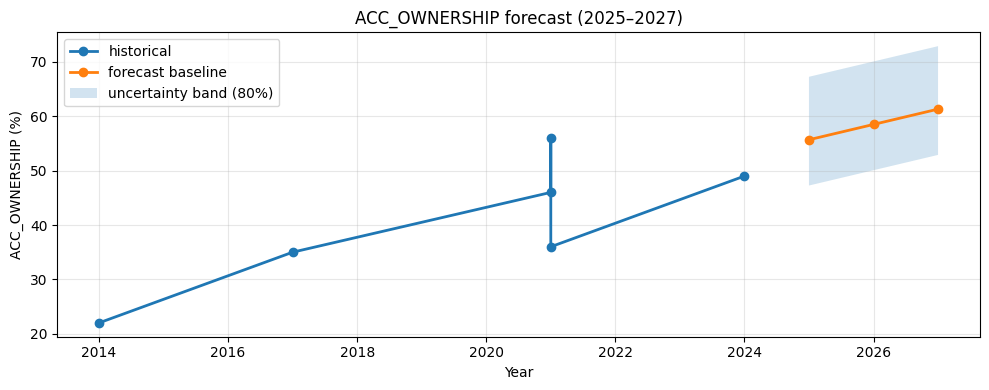

In [10]:
# %%
FORECAST_YEARS = [2025, 2026, 2027]
Xf = np.vstack([np.ones(len(FORECAST_YEARS)), np.array(FORECAST_YEARS)]).T
yhat = Xf @ beta

# Bootstrap residuals
rng = np.random.default_rng(42)
B = 3000
resid = acc["resid"].values

boot = np.zeros((B, len(FORECAST_YEARS)))
for i in range(B):
    eps = rng.choice(resid, size=len(FORECAST_YEARS), replace=True)
    boot[i, :] = yhat + eps

lo = np.percentile(boot, 10, axis=0)
hi = np.percentile(boot, 90, axis=0)

acc_forecast = pd.DataFrame({
    "indicator_code": "ACC_OWNERSHIP",
    "unit": acc["unit"].dropna().iloc[0] if acc["unit"].notna().any() else "",
    "year": FORECAST_YEARS,
    "baseline": yhat,
    "downside": lo,
    "upside": hi,
    "method": "linear_trend + bootstrap_residuals (80% interval)"
})

display(acc_forecast)

plt.figure(figsize=(10,4))
plt.plot(acc["year"], acc["y"], marker="o", linewidth=2, label="historical")
plt.plot(acc_forecast["year"], acc_forecast["baseline"], marker="o", linewidth=2, label="forecast baseline")
plt.fill_between(acc_forecast["year"], acc_forecast["downside"], acc_forecast["upside"], alpha=0.2, label="uncertainty band (80%)")
plt.title("ACC_OWNERSHIP forecast (2025–2027)")
plt.xlabel("Year")
plt.ylabel(f"ACC_OWNERSHIP ({acc_forecast['unit'].iloc[0]})" if acc_forecast["unit"].iloc[0] else "ACC_OWNERSHIP")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

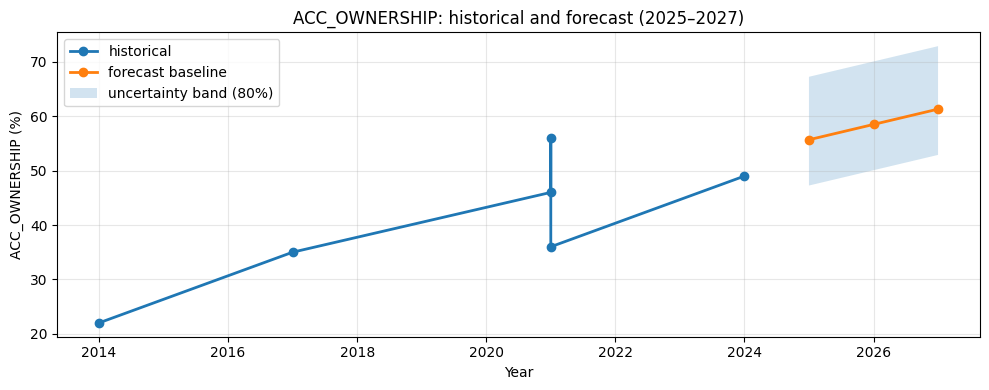

In [ ]:
# %% [markdown]
# ## 2) Sparse indicators: transparent scenario-based forecasts
#
# Because these series are too sparse for time-series estimation, we use simple, explainable rules:
# - Growth-from-last for `ACC_MM_ACCOUNT` (2 points).
# - Bounded adoption for `USG_TELEBIRR_USERS` (avoid exceeding market size).
# - Nominal scenario growth for `USG_P2P_VALUE` in ETB (inflation/volume sensitive).

In [11]:
# %%
def scenario_forecast_from_last(code: str, years: list[int], annual_growth_baseline: float, annual_growth_up: float, annual_growth_down: float):
    d = get_series(code)
    if d.empty:
        raise ValueError(f"No data for {code}")

    last_year = int(d["year"].max())
    last_val = float(d.loc[d["year"].idxmax(), "y"])
    unit = d["unit"].dropna().iloc[0] if d["unit"].notna().any() else ""

    rows = []
    for y in years:
        if y <= last_year:
            continue
        steps = y - last_year
        base = last_val * ((1 + annual_growth_baseline) ** steps)
        up = last_val * ((1 + annual_growth_up) ** steps)
        down = last_val * ((1 + annual_growth_down) ** steps)
        rows.append({
            "indicator_code": code,
            "unit": unit,
            "year": y,
            "baseline": base,
            "downside": down,
            "upside": up,
            "method": f"growth_from_last (last_year={last_year})"
        })
    return pd.DataFrame(rows)

def bounded_forecast_from_last(code: str, years: list[int], cap: float, baseline_rate: float, up_rate: float, down_rate: float):
    """
    Bounded growth: next = prev + rate*(cap - prev)
    """
    d = get_series(code)
    if d.empty:
        raise ValueError(f"No data for {code}")

    last_year = int(d["year"].max())
    last_val = float(d.loc[d["year"].idxmax(), "y"])
    unit = d["unit"].dropna().iloc[0] if d["unit"].notna().any() else ""

    def rollout(prev, rate):
        return prev + rate * (cap - prev)

    rows = []
    for y in years:
        if y <= last_year:
            continue
        steps = y - last_year

        base = last_val
        up = last_val
        down = last_val
        for _ in range(steps):
            base = rollout(base, baseline_rate)
            up = rollout(up, up_rate)
            down = rollout(down, down_rate)

        rows.append({
            "indicator_code": code,
            "unit": unit,
            "year": y,
            "baseline": base,
            "downside": down,
            "upside": up,
            "method": f"bounded_rollout(cap={cap}, last_year={last_year})"
        })
    return pd.DataFrame(rows)

YEARS = [2025, 2026, 2027]

In [12]:
# %%
# ACC_MM_ACCOUNT (2 points): modest scenario growth
acc_mm_fc = scenario_forecast_from_last(
    "ACC_MM_ACCOUNT",
    years=YEARS,
    annual_growth_baseline=0.10,
    annual_growth_up=0.18,
    annual_growth_down=0.04
)
display(acc_mm_fc)

,indicator_code,unit,year,baseline,downside,upside,method
0,ACC_MM_ACCOUNT,%,2025,10.39500,9.828000,11.151000,growth_from_last (last_year=2024)
1,ACC_MM_ACCOUNT,%,2026,11.43450,10.221120,13.158180,growth_from_last (last_year=2024)
2,ACC_MM_ACCOUNT,%,2027,12.57795,10.629965,15.526652,growth_from_last (last_year=2024)


In [ ]:
# %%
# USG_TELEBIRR_USERS has an observed 2025 point; forecast only after last_year (likely 2025)
tele_users_fc = bounded_forecast_from_last(
    "USG_TELEBIRR_USERS",
    years=YEARS,          # function will skip <= last_year automatically
    cap=90_000_000,
    baseline_rate=0.20,
    up_rate=0.30,
    down_rate=0.10
)
display(tele_users_fc)

Wrote: ../data/processed/task4_forecasts.csv


In [ ]:
# %%
# USG_P2P_VALUE is ETB nominal value; use wide scenario bounds
p2p_value_fc = scenario_forecast_from_last(
    "USG_P2P_VALUE",
    years=YEARS,          # skips <= last_year automatically
    annual_growth_baseline=0.18,
    annual_growth_up=0.30,
    annual_growth_down=0.05
)
display(p2p_value_fc)

In [ ]:
# %%
# Combine into one forecast table
forecast_table = pd.concat(
    [acc_forecast, acc_mm_fc, tele_users_fc, p2p_value_fc],
    ignore_index=True
).sort_values(["indicator_code","year"])

display(forecast_table)

In [ ]:
# %%
# Save artifact
OUT_PATH = "../data/processed/task4_forecasts.csv"
forecast_table.to_csv(OUT_PATH, index=False)
print("Wrote:", OUT_PATH)

In [ ]:
# %% [markdown]
# ## Write-up (Rubric)
#
# ### Model choices
# - **ACC_OWNERSHIP**: linear trend model because it has enough historical points (n=6). Uncertainty via bootstrap residuals.
# - **ACC_MM_ACCOUNT**: scenario growth because n=2 is too sparse for time-series estimation.
# - **USG_TELEBIRR_USERS**: bounded adoption because user counts are naturally capped (market saturation). Only forecast years after the last observed year.
# - **USG_P2P_VALUE (ETB)**: scenario nominal growth; highly sensitive to inflation/FX and digitization pace; wide bounds reflect uncertainty.
#
# ### Scenarios
# - **Baseline**: continuation of current trajectory.
# - **Upside**: faster adoption/transaction growth due to interoperability, competition, product improvements, and infrastructure.
# - **Downside**: slower growth due to macro constraints, regulatory friction, affordability, or adoption slowdown.
#
# ### Key uncertainty sources
# - Sparse/non-uniform data frequency and single-point series
# - Measurement/reporting changes across sources
# - Confounding events not explicitly modeled
#
# ### How Task 3 informs Task 4
# The event-impact narrative (e.g., Telebirr launch) supports the direction of scenario assumptions,
# even where the data is too sparse to estimate causal effects.